# Notes

We provide this notebook for inference and visualizations. 

You can either load images from a dataloader(see Sec. 1) or from a local path(see Sec. 2).

Welcome to join [IDEA](https://idea.edu.cn/en)([中文网址](https://idea.edu.cn/))!

In [10]:
import os, sys
import torch, json
import numpy as np

from main import build_model_main
from util.slconfig import SLConfig
from datasets import build_dataset
from util.visualizer import COCOVisualizer
from util import box_ops

# 0. Initialize and Load Pre-trained Models

In [11]:
model_config_path = "config/DINO/DINO_4scale_swin_archery.py" # change the path of the model config file
model_checkpoint_path = "logs/archery/checkpoint_best_regular.pth" # change the path of the model checkpoint
# See our Model Zoo section in README.md for more details about our pretrained models.

In [12]:
args = SLConfig.fromfile(model_config_path) 
args.device = 'cuda' 
model, criterion, postprocessors = build_model_main(args)
checkpoint = torch.load(model_checkpoint_path, map_location='cpu')
model.load_state_dict(checkpoint['model'])
_ = model.eval()

use_checkpoint!!!!!!!!!!!!!!!!!!!!!!!!
_IncompatibleKeys(missing_keys=['norm1.weight', 'norm1.bias', 'norm2.weight', 'norm2.bias', 'norm3.weight', 'norm3.bias'], unexpected_keys=['norm.weight', 'norm.bias', 'layers.0.blocks.1.attn_mask', 'layers.1.blocks.1.attn_mask', 'layers.2.blocks.1.attn_mask', 'layers.2.blocks.3.attn_mask', 'layers.2.blocks.5.attn_mask', 'layers.2.blocks.7.attn_mask', 'layers.2.blocks.9.attn_mask', 'layers.2.blocks.11.attn_mask', 'layers.2.blocks.13.attn_mask', 'layers.2.blocks.15.attn_mask', 'layers.2.blocks.17.attn_mask'])


In [4]:
# load coco names
with open('COCO_archery/annotations/instances_train2017.json') as f:
    id2name = json.load(f)
    id2name = id2name['categories']
    id2name = {cat['id']:cat['name'] for cat in id2name}

# 1. Visualize images from a dataloader
## 1.1 Load Datasets

In [6]:
args.dataset_file = 'coco'
args.coco_path = "COCO_archery/" # the path of coco
args.fix_size = False

dataset_val = build_dataset(image_set='val', args=args)   

data_aug_params: {
  "scales": [
    480,
    512,
    544,
    576,
    608,
    640,
    672,
    704,
    736,
    768,
    800
  ],
  "max_size": 1333,
  "scales2_resize": [
    400,
    500,
    600
  ],
  "scales2_crop": [
    384,
    600
  ]
}
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


## 1.2 Get an Example and Visualize it

In [7]:
image, targets = dataset_val[0]

In [9]:
image, targets

(tensor([[[1.1358, 1.1358, 1.1529,  ..., 2.1462, 2.1462, 2.1633],
          [1.1529, 1.1529, 1.1529,  ..., 2.1462, 2.1462, 2.1633],
          [1.1187, 1.1187, 1.1187,  ..., 2.1462, 2.1462, 2.1633],
          ...,
          [1.2385, 1.2385, 1.2214,  ..., 1.4269, 1.4098, 1.3584],
          [1.2385, 1.2385, 1.2214,  ..., 1.4098, 1.3755, 1.3413],
          [1.2385, 1.2385, 1.2214,  ..., 1.3755, 1.3755, 1.3584]],
 
         [[1.0980, 1.0980, 1.1155,  ..., 2.0434, 2.0434, 2.0609],
          [1.1155, 1.1155, 1.1155,  ..., 2.0434, 2.0434, 2.0609],
          [1.1331, 1.1331, 1.1331,  ..., 2.0434, 2.0434, 2.0609],
          ...,
          [1.4132, 1.4132, 1.3957,  ..., 1.6583, 1.6408, 1.5882],
          [1.4132, 1.4132, 1.3957,  ..., 1.6408, 1.6057, 1.5707],
          [1.4132, 1.4132, 1.3957,  ..., 1.6057, 1.6057, 1.5882]],
 
         [[0.7751, 0.7751, 0.7925,  ..., 1.6988, 1.6988, 1.7163],
          [0.7925, 0.7925, 0.7925,  ..., 1.6988, 1.6988, 1.7163],
          [0.7925, 0.7925, 0.7925,  ...,

In [ ]:
# build gt_dict for vis
box_label = [id2name[int(item)] for item in targets['labels']]
gt_dict = {
    'boxes': targets['boxes'],
    'image_id': targets['image_id'],
    'size': targets['size'],
    'box_label': box_label,
}
vslzr = COCOVisualizer()
vslzr.visualize(image, gt_dict, savedir=None)

## 1.3 Visualize Model Predictions

In [ ]:
output = model.cuda()(image[None].cuda())
output = postprocessors['bbox'](output, torch.Tensor([[1.0, 1.0]]).cuda())[0]

In [9]:
thershold = 0.3 # set a thershold

scores = output['scores']
labels = output['labels']
boxes = box_ops.box_xyxy_to_cxcywh(output['boxes'])
select_mask = scores > thershold

In [ ]:
box_label = [id2name[int(item)] for item in labels[select_mask]]
pred_dict = {
    'boxes': boxes[select_mask],
    'size': targets['size'],
    'box_label': box_label
}
vslzr.visualize(image, pred_dict, savedir=None)

# 2. Visualize Custom Images

In [5]:
from PIL import Image
import datasets.transforms as T

In [9]:
image = Image.open("all_frames/000000.png").convert("RGB") # load image

In [ ]:
# transform images
transform = T.Compose([
    #T.RandomResize([800], max_size=1333),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
image, _ = transform(image, None)

In [8]:
# predict images
output = model.cuda()(image[None].cuda())
output = postprocessors['bbox'](output, torch.Tensor([[1.0, 1.0]]).cuda())[0]

/home/ubuntu/anaconda3/envs/dino/lib/python3.7/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448224956/work/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


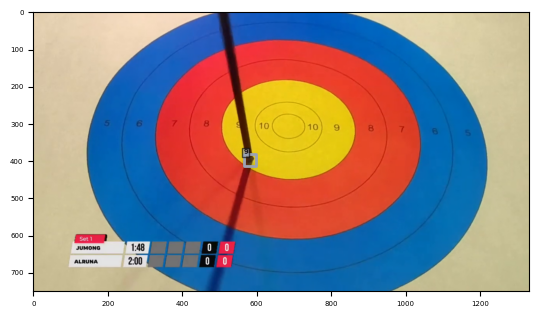

savename: .//0-2023-01-12-15:35:56.390818.png


AttributeError: 'COCOVisualizer' object has no attribute 'visualize_cv'

In [24]:
# visualize outputs
thershold = 0.5 # set a thershold

vslzr = COCOVisualizer()

scores = output['scores']
labels = output['labels']
boxes = box_ops.box_xyxy_to_cxcywh(output['boxes'])
select_mask = scores > thershold

box_label = [id2name[int(item)] for item in labels[select_mask]]
pred_dict = {
    'boxes': boxes[select_mask],
    'size': torch.Tensor([image.shape[1], image.shape[2]]),
    'box_label': box_label,
    'image_id': '0'
}
vslzr.visualize(image, pred_dict, savedir='./', dpi=100)
vslzr.visualize_cv(image, pred_dict, savedir='./')